<img src="./logo_UNSAM.jpg" align= "right" width= "150" /> -->
## APS
## Trabajo práctico semanal 7: *Filtrado digital lineal*
### Violeta Manterola

Usando el archivo ecg.mat que contiene un registro electrocardiográfico (ECG) registrado durante una prueba de esfuerzo, junto con una serie de variables descriptas a continuación. Diseñe y aplique los filtros digitales necesarios para mitigar las siguientes fuentes de contaminación:


Ruido causado por el movimiento de los electrodos (Alta frecuencia).
Ruido muscular (Alta frecuencia).
Movimiento de la línea de base del ECG, inducido en parte por la respiración (Baja frecuencia).

In [44]:
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt
from pytc2.sistemas_lineales import plot_plantilla#, group_delay
import scipy.io as sio

#%%importo señal ECG
mat_struct = sio.loadmat('./ECG_TP4.mat')
ecg_one_lead =(mat_struct['ecg_lead']).flatten()
N = len(ecg_one_lead)
cant_muestras = N
fs = 1000
nyq = fs / 2

#%%función para mostrar la plantilla tanto para los filtros FIR como IIR
def plot_plantilla_filtros(w, h, label, fpass, fstop, ripple, attenuation, fs, title=''):
    """Grafica la respuesta en frecuencia y superpone la plantilla del filtro FIR"""
    # plt.figure(figsize=(10, 4))
    plt.figure()
    plt.plot(w, 20 * np.log10(np.abs(h) + 1e-12), label=label)
    plot_plantilla(
        filter_type='bandpass',
        fpass=fpass,
        fstop=fstop,
        ripple=ripple,
        attenuation=attenuation,
        fs=fs
    )
    plt.title(title)
    plt.xlabel('Frecuencia [Hz]')
    plt.ylabel('Magnitud [dB]')
    plt.legend()
    plt.grid(True)
    plt.show()

#%%funcion para que muestre el filtrado del ecg en distintas regiones, algunas sin ruido: para mostrar que no modifica la señal de no..
# y otras con rudio donde la señal debe ser filtrada 
def mostrar_filtrado_ecg(ecg_original, ecg_filtrado_o_filtro, fs, etiqueta='ECG Filtrado', tipo_filtro=None):
    """
    Muestra el ECG original y uno filtrado en regiones con y sin ruido.
    Parámetros:
    - ecg_original: señal ECG original
    - ecg_filtrado_o_filtro: o la señal ECG ya filtrada, o los coeficientes del filtro
    - fs: frecuencia de muestreo
    - etiqueta: nombre del filtro usado (para la leyenda)
    - tipo_filtro: 'FIR' o 'IIR' si se están pasando coeficientes del filtro
    """
    # --- Si se pasa un filtro y no una señal filtrada
    if tipo_filtro is not None:
        
        if tipo_filtro == 'FIR': #los FIR VAN CON lfilter PARA DEMOSTRAR Q LA FASE ES LINEAL SOLO PRESENTA UN RETARDO DE GRUPO
            ecg_filtrado = sig.lfilter(ecg_filtrado_o_filtro, [1], ecg_original)
        
        elif tipo_filtro == 'IIR': # LOS IIR VAN CON FILTFILT PARA CORREGIR LA DISTORSIÓN DE FASE QUE TIENEN 
            ecg_filtrado = sig.sosfiltfilt(ecg_filtrado_o_filtro, ecg_original)
        else:
            raise ValueError("tipo_filtro debe ser 'FIR' o 'IIR'")
    else:
        # Ya se pasó la señal filtrada
        ecg_filtrado = ecg_filtrado_o_filtro

    # --- Regiones SIN ruido
    regiones_sin_ruido = [(4000, 5500), (10000, 11000),(5 * 60 * fs, 5.2 * 60 * fs)]
    for inicio, fin in regiones_sin_ruido:
        zoom_region = np.arange(int(inicio), int(fin))
        plt.figure(figsize=(10, 4))
        plt.plot(zoom_region, ecg_original[zoom_region], label='ECG Original', linewidth=2)
        plt.plot(zoom_region, ecg_filtrado[zoom_region], color='magenta',label=etiqueta)
        plt.title(f'Filtrado en región sin ruido [{inicio}, {fin}]')
        plt.xlabel('Muestras')
        plt.ylabel('Amplitud')
        plt.legend()
        plt.grid(True)
        plt.show()

    # --- Regiones con ruido
    regiones_ruido = [
        (12 * 60 * fs, 12.4 * 60 * fs),
        (15 * 60 * fs, 15.2 * 60 * fs)
    ]
    for inicio, fin in regiones_ruido:
        zoom_region = np.arange(int(inicio), int(fin))
        plt.figure(figsize=(10, 4))
        plt.plot(zoom_region, ecg_original[zoom_region], label='ECG Original', linewidth=2)
        plt.plot(zoom_region, ecg_filtrado[zoom_region], color='magenta',label=etiqueta)
        plt.title(f'Filtrado en región con ruido [{int(inicio)}, {int(fin)}]')
        plt.xlabel('Muestras')
        plt.ylabel('Amplitud')
        plt.legend()
        plt.grid(True)
        plt.show()


----------------------------------------------------------------------------------------------------------------------------------------
### **Diseño plantilla:**

La plantilla fue diseñada teniendo en cuenta la naturaleza fisológica de la señal que se quiere analizar. En este caso trabajamos con una señal de un electrocardiograma que representa la actividad eléctrica del corazón, s edebe tener en cuenta el rango de freceucnias que presenta para así poder establecer una bada de paso (donde la señal no será modificada) y aquellas frecuencias que no pertenezcan serán atenuadas. Para esto se tuvo en cuenta el ancho de banda del ECG en cuestión obteniedo en un trabajo previo ()

Se seleccionó una banda de paso de 1Hz a 35Hz teniendo en cuenta que las componentes principales del ECG e encuentran dentro de ese rango; como lo son la onda P, el complejo QRS y la onda T. Por debajo tenemos rudio de baja frecuencia asociadas a artefactos de movimiento o fluctuaciones basales lentas. Por encima de los 35Hz las frecuencias tienden a estar contaminadas con ruido muscular o interferencias de red.

Teniendo en cuenta esto las bandas de detención fueron configuradas en 0.1Hz para mitigar las mencionadas intereferencias de baja frecuencia, donde se destaca el movimiento de la línea de base del ECG, inducido en parte por la respiración (suele estar por debajo de 0.5 Hz). En el otro extremo se configuró un limite de 50Hz ya que es la frefucencia de la red eléctrica en nuestro país. 

Por último, el ripple (rizado en banda de paso) se fijó en 1 dB, un valor razonablemente bajo que permite preservar la morfología de la señal ECG sin exigir demasiado al diseño del filtro. Mientras que la atenuación en banda de detención en 40 dB, lo cual implica una reducción de un factor de 100 en amplitud, suficiente para eliminar el ruido fuera de la banda de interés sin necesidad de un filtro de orden excesivamente alto.


--------------------------------------------------------------------------------------------------------------------------

## FILTROS FIR
##### *Finite Impulse Response*


En primer lugar tenemos los filtros FIR (son filtros finitos, es decir, NO recursivos) lo que implica que tienen una respuesta finita al impulso. Su principal característica y ventaja es que garantizan la estabilidad ya que asegura que la respuesta se estabilizará en 0 después de un determinado tiempo.

Además, tienen la posibilidad de que pueden ser diseñados para que tengan una respuesta de fase LINEAL. Esto quiere decir que la señal no será distorsionada en el tiempo, solo tiene presentan una demora igual en todas las frecuencias por eso no se distorsiona, esa demora es la pendiente de la recta que queda como respuesta en frecuecnai de fase. 

Existen disversas formas de diseñar filtros FIR: 

 - método ventanas: más sencillo de enteder pero solo pueden modificarse una cantidad limitada de parámetros.
 - método cuadrados mínimos
 - método Parks-Mc Clellan-Remez: 

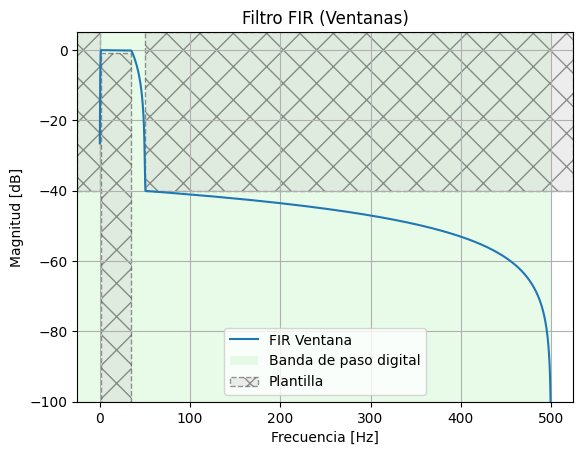

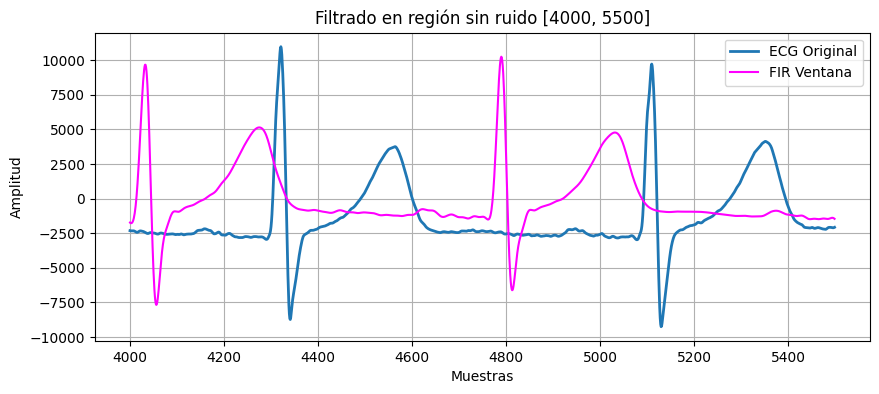

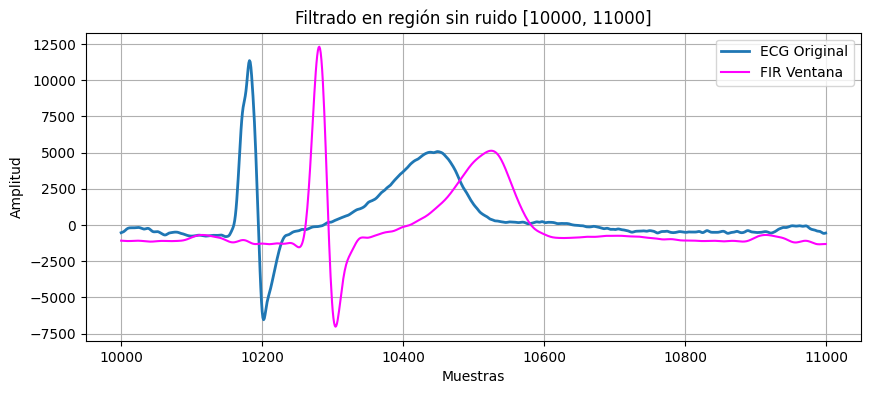

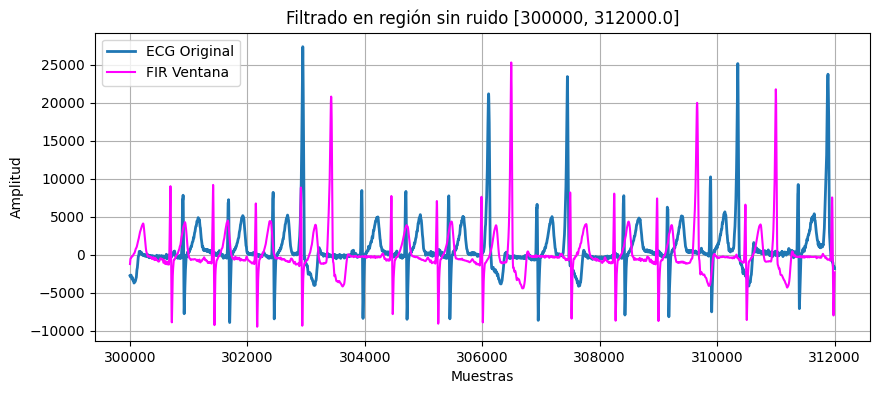

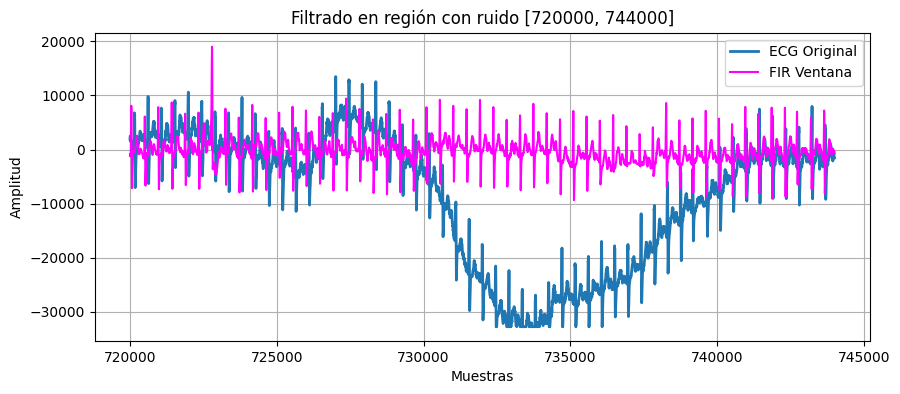

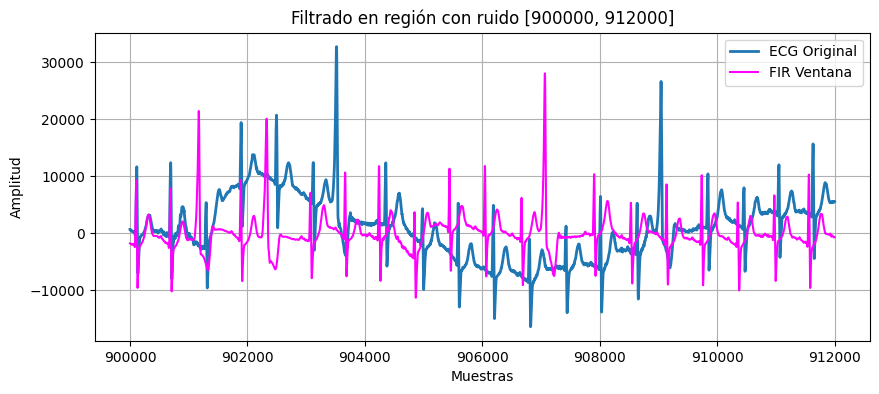

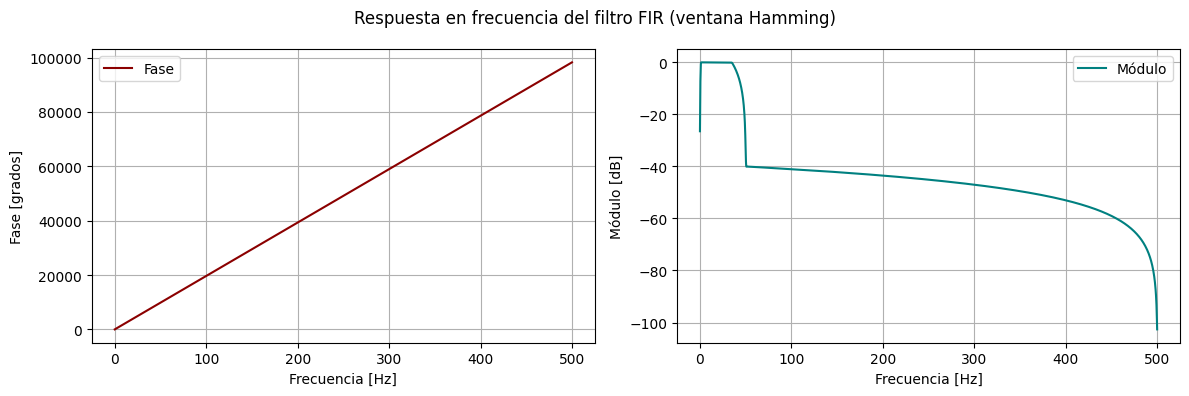

In [55]:
# FILTROS FIR

#método ventanas (en este caso Hamming)
# combinación de un filtro pasa-bajos con un filtro pasa-altos (por convolución)

# --- PASA-ALTOS ---------------------------------------------------------
fstop_hp = 0.1
fpass_hp = 1
cant_coef_hp = 5101 # más largo, transición muy angosta
frecs_hp = np.array([0, fstop_hp, fpass_hp, nyq]) / nyq
gains_hp_db = [-np.inf, -40, -0.1, 0]  # en dB → 0 dB en stop, transición, luego 0 dB en paso (lineal será 1)
gains_hp = 10**(np.array(gains_hp_db) / 20)

num_hp = sig.firwin2(cant_coef_hp, frecs_hp, gains_hp, window='hamming')

# --- PASA-BAJOS ---------------------------------------------------------
fpass_lp = 35
fstop_lp = 50
cant_coef_lp = 2001 # menos exigente
frecs_lp = np.array([0, fpass_lp, fstop_lp, nyq]) / nyq
gains_lp_db = [0, -0.1, -40, -np.inf]  # en dB → pasa, transición, luego stop
gains_lp = 10**(np.array(gains_lp_db) / 20)

num_lp = sig.firwin2(cant_coef_lp, frecs_lp, gains_lp, window='hamming') #

# --- COMBINACIÓN: FIR pasabanda por convolución-----------------------------------------------------------------
FIR_bp_ventana= np.convolve(num_hp, num_lp)

#------ OBTENGO w,h ---> RESPUESTA EN FRECUENCIA
w1, h1 = sig.freqz(FIR_bp_ventana, worN=2048, fs=fs)
plot_plantilla_filtros(w1, h1, label='FIR Ventana', fpass=(fpass_hp, fpass_lp), fstop=(fstop_hp, fstop_lp), ripple=1, attenuation=40, fs=fs, title='Filtro FIR (Ventanas)')

mostrar_filtrado_ecg(ecg_one_lead, FIR_bp_ventana, fs, etiqueta='FIR Ventana', tipo_filtro='FIR')

# --- VISUALIZACIÓN RESPUESTA EN FRECUENCIA-------------------#
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(w1, np.unwrap(np.angle(h1)) * 180 / np.pi, color='darkred',label='Fase')
plt.ylabel('Fase [grados]')
plt.xlabel('Frecuencia [Hz]')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.subplot(1, 2, 2)
plt.plot(w1, 20 * np.log10(np.abs(h1) + 1e-12), color='teal', label='Módulo')
plt.ylabel('Módulo [dB]')
plt.xlabel('Frecuencia [Hz]')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.suptitle('Respuesta en frecuencia del filtro FIR (ventana Hamming)')
plt.tight_layout()
plt.show()

### **- Análisis - Método de ventanas:**

Para este método se utilizó una combinación de un filtro pasa-altos con uno pasa-bajos mediante convolución para armar un pasabanda. Ya que al convolucionar en el tiempo estoy multiplicsando en frecuencia, po lo tanto, si multiplico frecuencia de un pasa-bajos, que permite el paso de frecuencias menores a la de corte, con un pasa-altos, que permite que pasen frecuencias mayores a la de corte, obtengo como resultado la interesección entre estos intervalos de frecunecia, mi banda de paso de este filtro pasa-banda. Se opta por hacer la convolución entre estos dos filtros porque quiero tener un mayor control sobre la banda de paso y poder así diseñar con mayor facilidad los extremos por separado. 

Sin embargo, demanda muchos coeficientes, ya que la banda de transición que se pretende para el filtro pasa-altos es más exigente, ya que resulta una banda de transición angosta: solo 0.4 Hz entre stop y pass; esto hace que el FIR requiera de muchos coeficientes para que la transición sea suave y definida en el borde inferior del filtro pasabanda. En cambio, la banda de transicón del filtro pasa-bajos es menos exigente (15Hz) por lo tanto requiere de menos coeficientes para poder así cumplir con la plantilla, resultando así en una transicón menos abrupta en el borde superior del filtro-pasabanda

En cuanto al análisis de los graficos, los primero tres corresponden a fragmentos del ECG sin ruido (o mínimo) verificando que el filtro cumple con lo esperado ya que no distorsiona la respuesta, como fue explicado, solo presenta un retardo, que puede solucionarse facilmente: analizando de cuanto es esta demora y luego se suma dicha magnitud a la señal filtrada. Mientras que los ultimos dos fragmentos corresponden a tramos del ECG ruidoso y efectivamente puede verse como la señal es filtrada. Esto concide con lo planteado previamente, si se ve su respuesta en frecuencia de fase, es lineal, verificando que no distorsiona la frecuencia solo le aplica una demora constante.  

-------------------------------------------------------------------------------

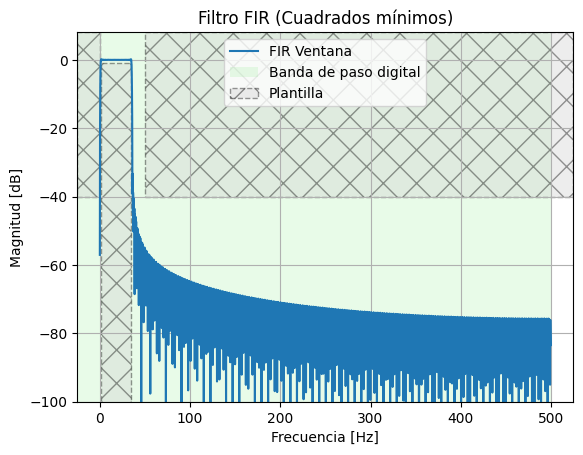

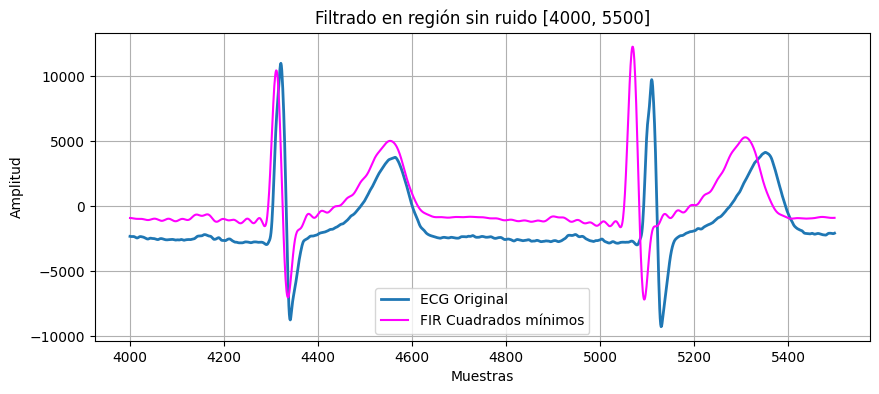

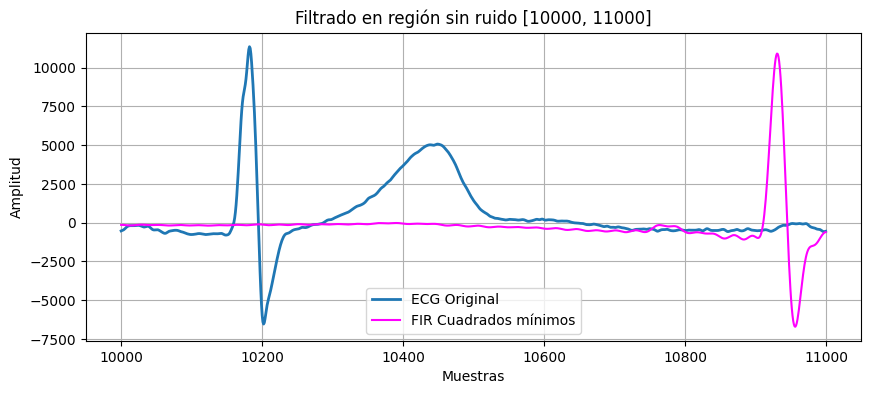

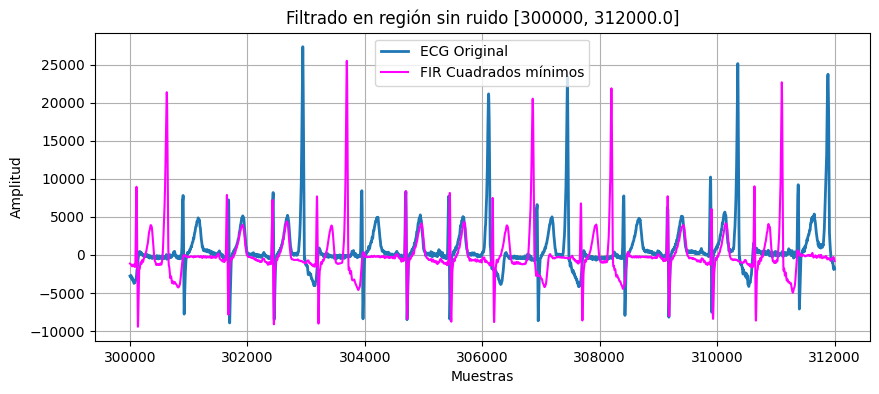

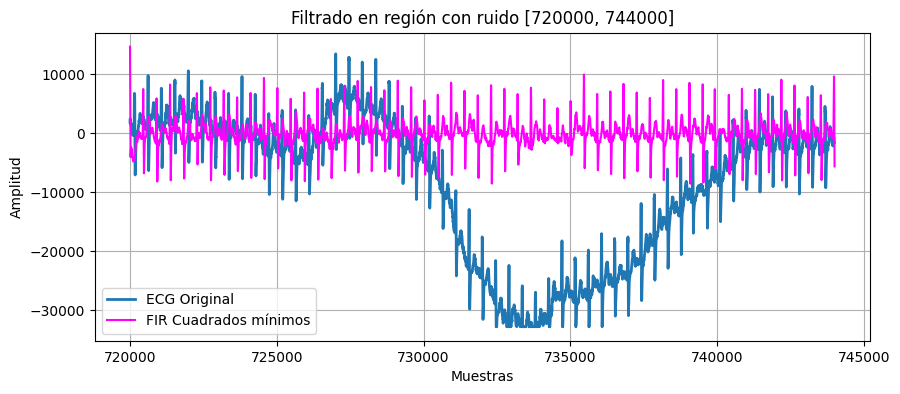

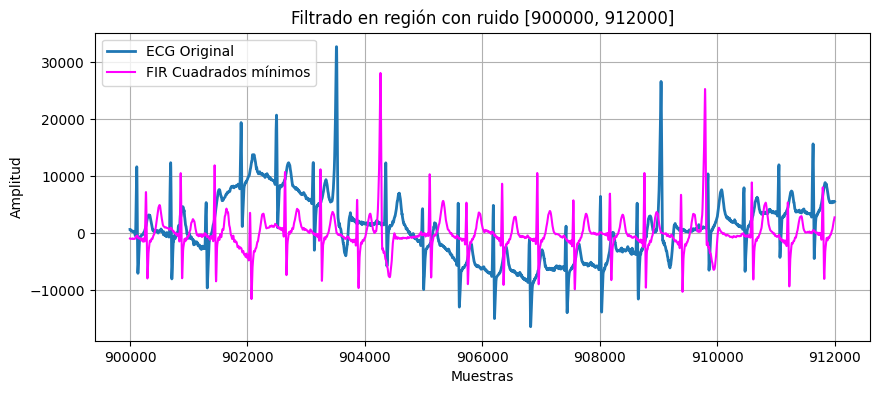

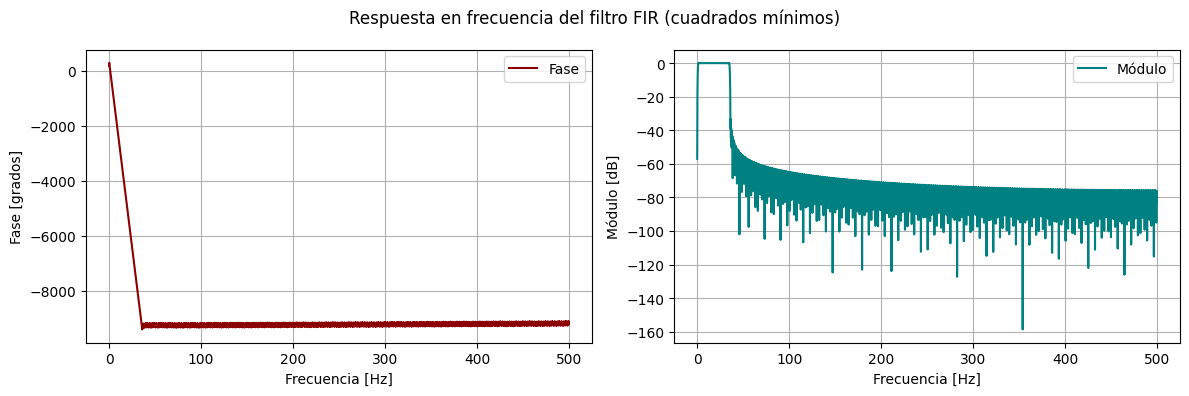

In [58]:
#método cuadrados mínimos

ripple = 1         # dB
attenuation = 40   # dB

fpass = ( [1.0,35.0])
fstop = ([.1,50.0])
bands = np.array([0, fstop[0], fpass[0], fpass[1], fpass[1]+1, nyq]) #sumandole asi 1 lo hago simetrico -->transición de 1Hz en ambas bandas
desired = np.array([0, 0, 1, 1, 0, 0])

FIR_lsq = sig.firls(numtaps = 1501, bands= bands,desired=desired, fs=fs) #lsq = lowsquare = cuadrados mínimos

w2, h2 = sig.freqz(FIR_lsq, worN=2048, fs=fs)
plot_plantilla_filtros(w2, h2, label='FIR Ventana', fpass=(fpass[0], fpass[1]), fstop=(fstop[0], fstop[1]), ripple=1, attenuation=40, fs=fs, title='Filtro FIR (Cuadrados mínimos)')

mostrar_filtrado_ecg(ecg_one_lead, FIR_lsq, fs, etiqueta='FIR Cuadrados mínimos', tipo_filtro='FIR')

# --- VISUALIZACIÓN RESPUESTA EN FREUENCIA -----------------------------------------------------------------------
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(w2, np.unwrap(np.angle(h2)) * 180 / np.pi, color='darkred',label='Fase')
plt.ylabel('Fase [grados]')
plt.xlabel('Frecuencia [Hz]')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.subplot(1, 2, 2)
plt.plot(w2, 20 * np.log10(np.abs(h2) + 1e-12), color='teal', label='Módulo')
plt.ylabel('Módulo [dB]')
plt.xlabel('Frecuencia [Hz]')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.suptitle('Respuesta en frecuencia del filtro FIR (cuadrados mínimos)')
plt.tight_layout()
plt.show()

### **- Análisis - Método de cuadrados mínimos:**

En este caso, a diferencia del método basado en ventanas, se optó por forzar la simetría de la plantilla del filtro. Esto se debe a que originalmente la banda de transición no era simétrica: del lado del pasa-altos la transición era de apenas 0.9 Hz, mientras que del lado del pasa-bajos era de 15 Hz. Para equilibrar esta asimetría, se decidió extender artificialmente el límite superior de la banda de paso sumando 1 Hz, lo cual genera una banda de transición más pareja (de 1 Hz aproximadamente a ambos lados). De esta manera se mejora la estabilidad y el comportamiento del filtro, especialmente cuando se usa un diseño como firls, que intenta minimizar el error cuadrático en las regiones especificadas.

La transición es algo más abrupta que la del primer filtro (método de ventans), lo cual indica una mejor eficiencia en términos de orden, ya que es de orden menor; pero presenta mayor ripple en la banda de atenuación. 

Al igual que el método anterior tenemos un retardo de grupo, porque seguimos trabajando con filtros FIR! Pero como ya aclaramos es algo sencillo de corregir, lo importante es que no distorsiona la morfología de la señal, algo importante al analizar señales del tipo fisológicas. Analizando los gráficos del filtrado para poder corroborar la performance del filtro vemos que resulta inocuo en la señal limpia ya que actúa como un sistema de ganancia unitaria con solo una demora. En cambio, en las regiones ruidosas, el filtro actúa de forma efectiva, atenuando las componentes fuera de la banda de interés sin afectar significativamente el contenido útil de la señal.

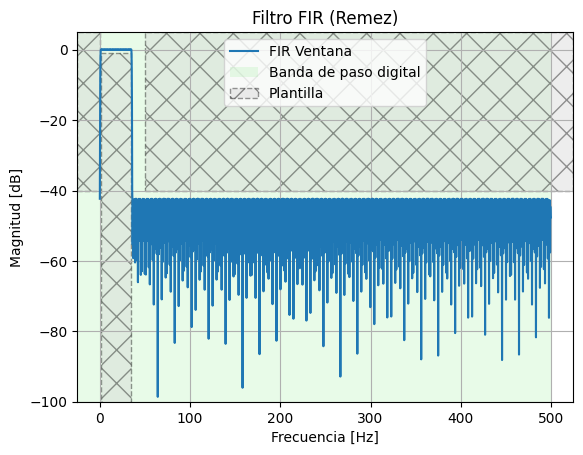

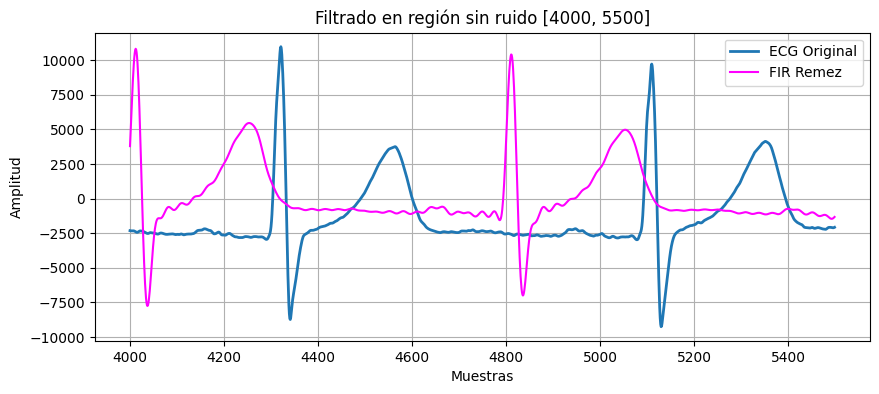

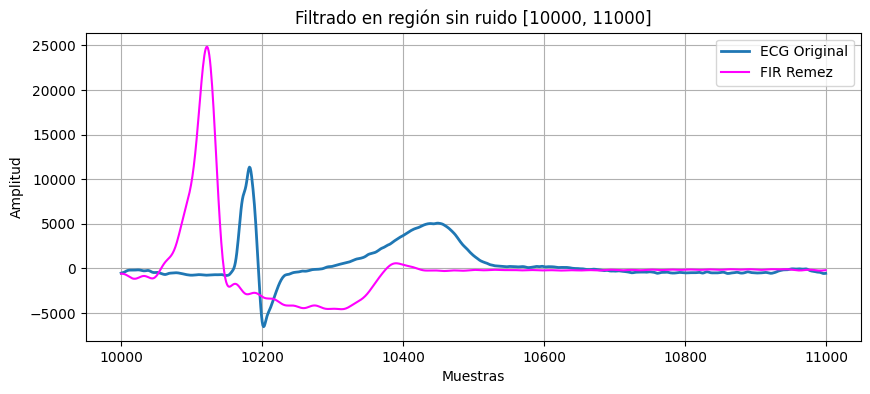

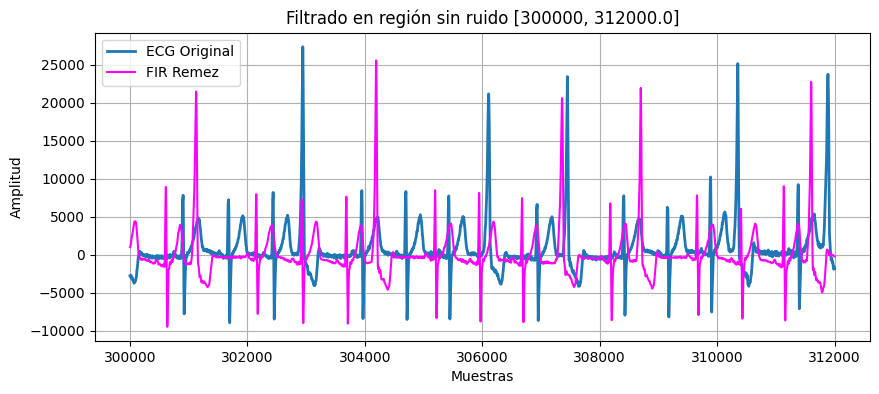

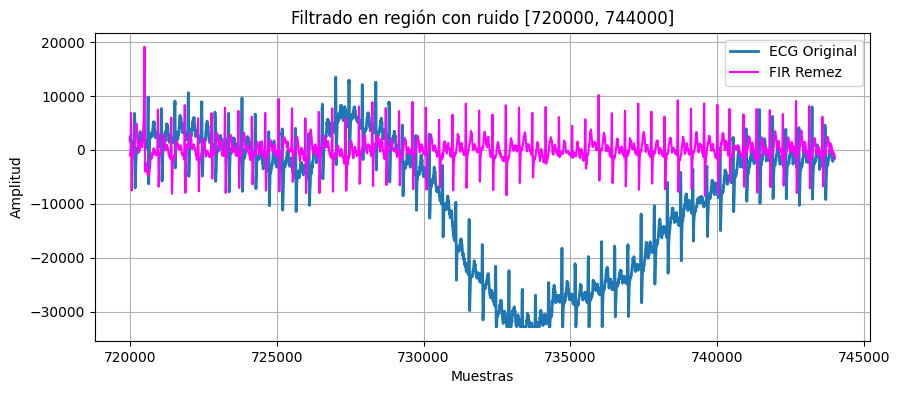

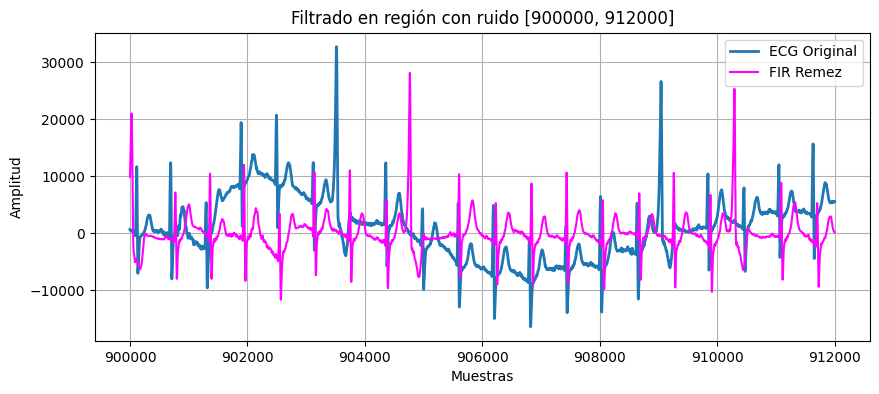

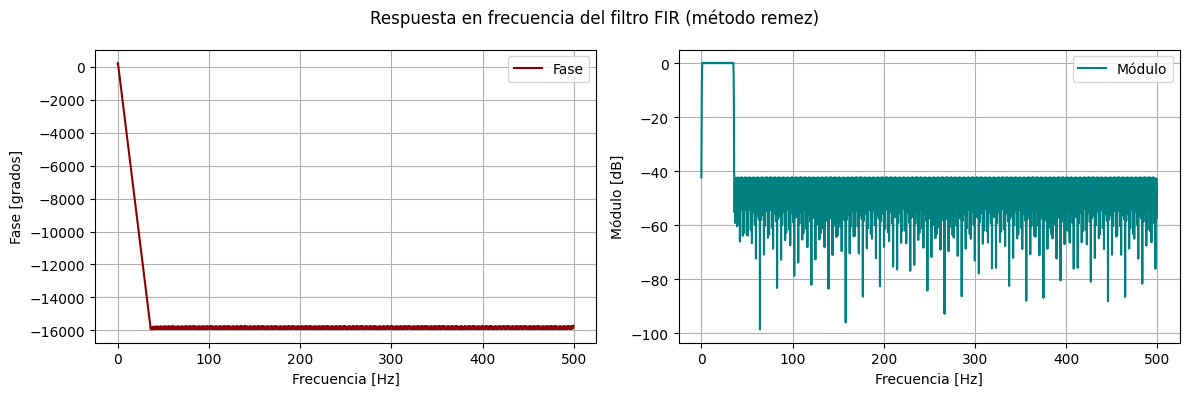

In [59]:
# método remez
fpass = ( [1.0,35.0])
fstop = ([.1,50.0])
bands_1 = np.array([0, fstop[0], fpass[0], fpass[1], fpass[1]+1, nyq])
desired_1 = np.array([0, 0, 1, 1, 0, 0])

FIR_remez = sig.remez(2501, bands_1, desired_1[::2], fs=fs)

w3, h3 = sig.freqz(FIR_remez, worN=2048, fs=fs)
plot_plantilla_filtros(w3, h3, label='FIR Ventana', fpass=(fpass[0], fpass[1]), fstop=(fstop[0], fstop[1]), ripple=1, attenuation=40, fs=fs, title='Filtro FIR (Remez)')

mostrar_filtrado_ecg(ecg_one_lead, FIR_remez, fs, etiqueta='FIR Remez', tipo_filtro='FIR')

# --- VISUALIZACIÓN RESPUESTA EN FRECUENCIA-------------------#
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(w3, np.unwrap(np.angle(h3)) * 180 / np.pi, color='darkred',label='Fase')
plt.ylabel('Fase [grados]')
plt.xlabel('Frecuencia [Hz]')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.subplot(1, 2, 2)
plt.plot(w3, 20 * np.log10(np.abs(h3) + 1e-12), color='teal', label='Módulo')
plt.ylabel('Módulo [dB]')
plt.xlabel('Frecuencia [Hz]')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.suptitle('Respuesta en frecuencia del filtro FIR (método remez)')
plt.tight_layout()
plt.show()

### **- Análisis - Método de Parks-Mc Clellan (Remez):**
En este caso se utilizó el algoritmo de Parks–McClellan (remez), empleando la misma plantilla de diseño que en el caso por cuadrados mínimos con la modificación para hacerlo simétrico y así equilibrar las bandas de transición y asegurar un comportamiento más controlado. Este algoritmo busca minimizar el error máximo entre la respuesta en frecuencia deseada y la respuesta del filtro implementado. 
Este método se basa en la minimización del error de Chebyshev (minimax), lo que produce un filtro FIR con respuesta óptima en términos de equirriple: las ondulaciones en cada banda están distribuidas uniformemente, maximizando la eficiencia para una cantidad dada de coeficientes.

Este método se detaca ya que es el que tiene la transición más abrupta de los tres (más vertical --> mayor pendiente), lo que indica que es el más eficiente en términos de ancho de transición. Pero presenta un ripple significativo en la banda de atenuación y a difrencia del metodo de cuadrados mínimos este no se minimiza sino que es constante durante toda la banda. 

Al igual que los filtros anterioires en regiones limpias de la señal se observa nuevamente que el filtro no altera la morfología del ECG (solo presenta un desplazamineto por la demora) debido a la linealidad de fase del FIR, pero sin distorsión. En regiones contaminadas por ruido (gráfico inferior), el filtro demuestra ser efectivo atenuando las componentes fuera de la banda de paso. 


-------------------------------------------------------------------------------------------------------------------------------------------------
## FILTROS IIR
##### *Infinite Impulse Response*


Los filtros IIR se caracterizan por tener una respuesta al impulso infinita, lo que significa que, en teoría, su salida nunca se anula completamente  tras una excitación puntual (pueden oscilar indefinidamente). Esto se debe a su naturaleza recursiva, ya que utilizan retroalimentación (coeficientes en el denominador del sistema). Por lo tanto, resultan potencialmente inestables si no se controlan adecuadamente los polos. Sin embargo, su ventaja es que a comparación de los filtros FIR pueden alcanzar el mismo nivel de performance con un menor orden, por lo tanto implica un menor costo computacional, algo especialmente importante en sistemas embebidos o en tiempo real.

En este caso, se analizaron 3 tipos distintos de filtros recursivos: 

 - Butterworth: de máxima planicidad en banda de paso. No presenta ripple, pero tiene una transición más lenta en frecuencia.
 - chebyshev: Presenta ripple en la banda de paso. 
 - Cauer (elíptico): ripple en la badna de paso y en la de atenuación. 

Orden del filtro IIR: 30


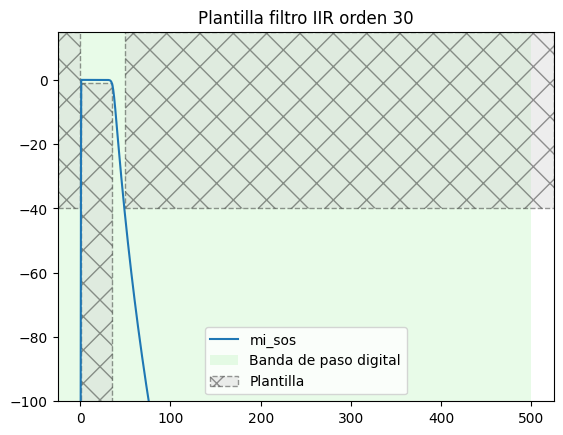

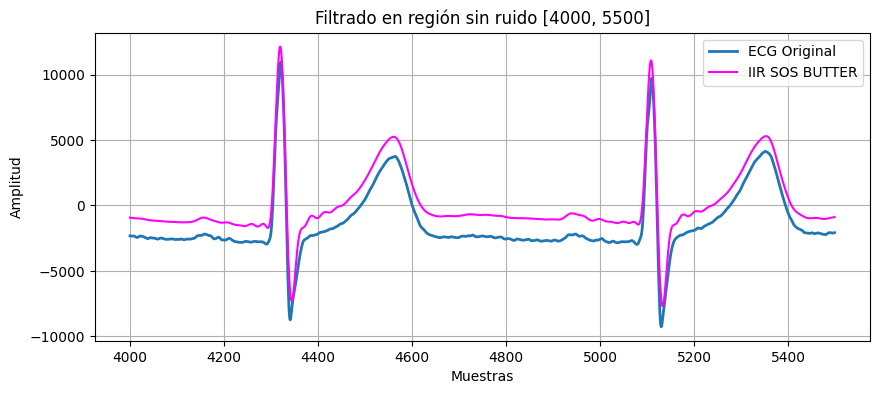

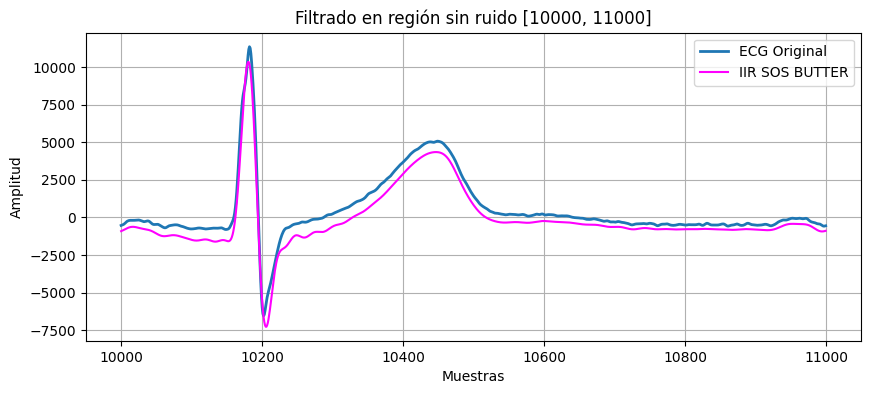

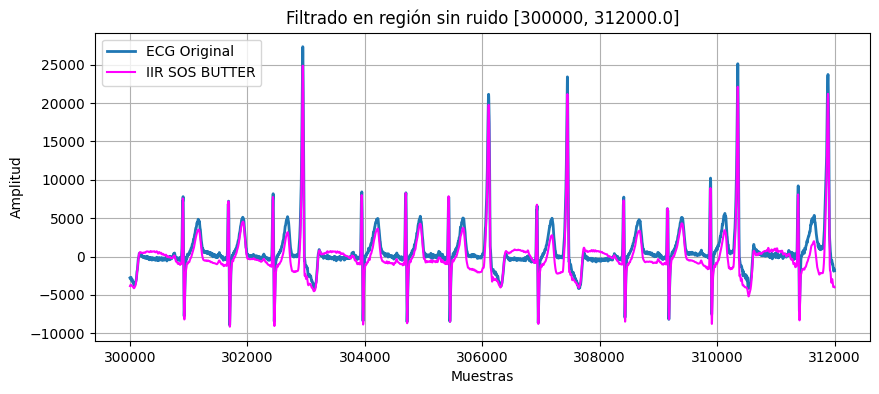

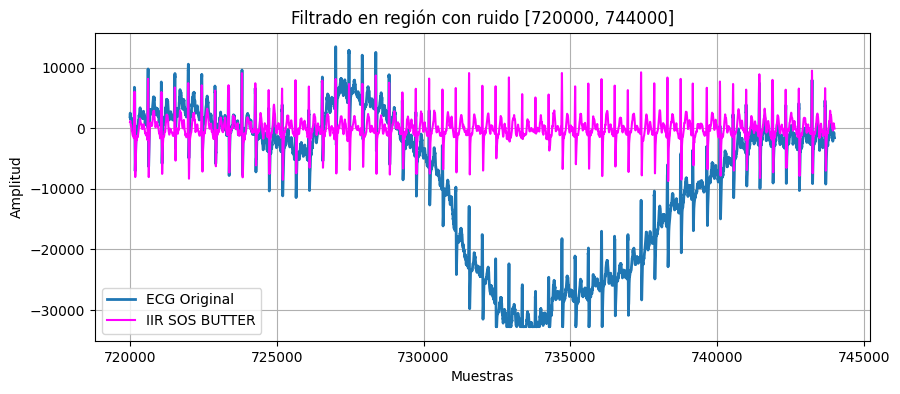

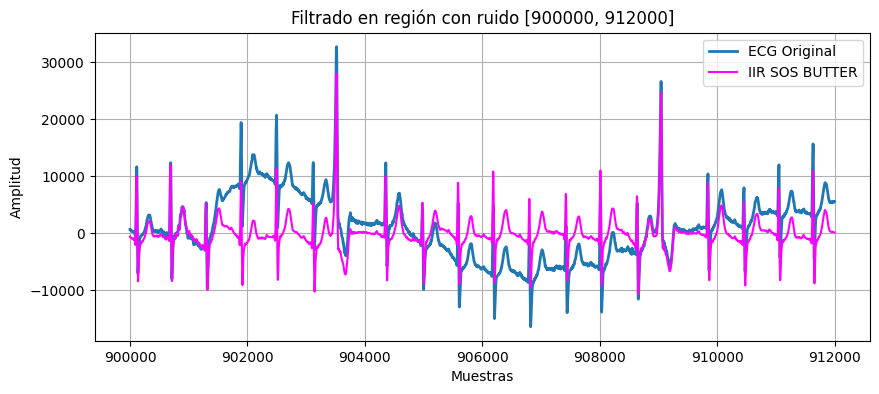

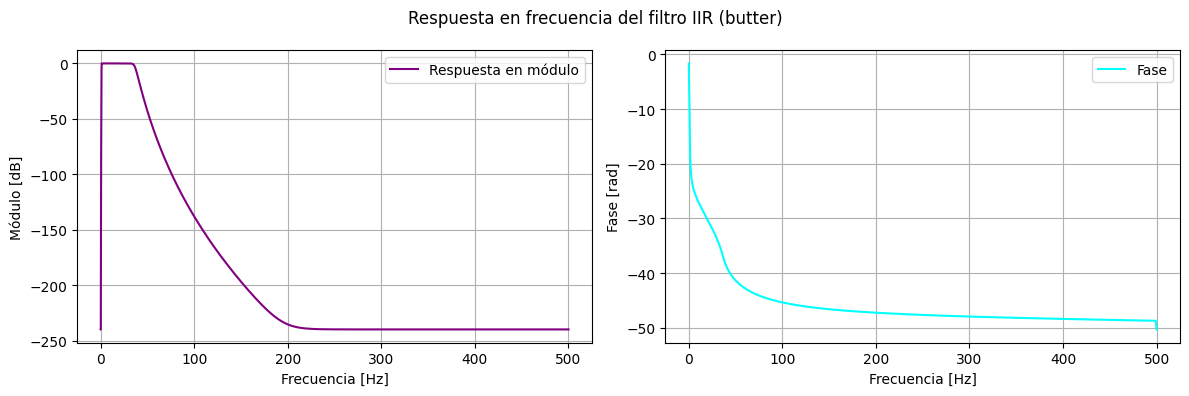

In [45]:
aprox_name = 'butter'
fs = 1000
nyq_frec = fs/2
fpass= np.array([1.0,35.0]) #banda de paso wp
ripple = 1 #dB
fstop= ([.1,50.]) #comienzo banda de atenuación, hasta 50 (interferencia de la red eléctrica)
attenuation = 40 #dB

mi_sos = sig.iirdesign(fpass, fstop, ripple, attenuation, ftype=aprox_name, output='sos',fs=fs)
# las columnas 3,4y5 son los coeficiente a0,a1,a2 y de la 0 a la 2 son los coef b

orden_iir = mi_sos.shape[0] * 2  # cada sección SOS es un biquadro (orden 2)
print(f"Orden del filtro IIR: {orden_iir}") #para verificar de que orden es cada filtro y así poder comparar 

#%%plantilla de diseño, para analizarlo
npoints = 1000 #asi evalua equiespaciado

#para obtner mayor resuloción antesd e la bandad de paso, necesito un muestreo log => a freqz le puedo pasar un vector.
w_rad = np.append(np.logspace(-2,0.8,250), np.logspace(0.9,1.6,250))
w_rad = np.append(w_rad, np.linspace(40, nyq_frec, 500, endpoint=True) )/nyq_frec * np.pi

w, hh = sig.sosfreqz(mi_sos, worN=w_rad) #worN le puedo pasar un entero o un vector 
plt.plot(w/np.pi*nyq_frec, 20*np.log10(np.abs(hh)+1e-15), label='mi_sos')

plot_plantilla(filter_type = 'bandpass' , fpass = (fpass[0],fpass[1]), ripple = ripple , fstop = (fstop[0],fstop[1]), attenuation = attenuation, fs = fs)
plt.title(f'Plantilla filtro IIR orden {orden_iir}')
plt.legend()
plt.show()

mostrar_filtrado_ecg(ecg_one_lead, mi_sos, fs, etiqueta='IIR SOS ' + aprox_name.upper(), tipo_filtro='IIR')

##-------------------- VISUALIZACIÓN RESPUESTA EN FRECUENCIA-----------------##
plt.figure(figsize=(12, 4))

# Respuesta en módulo
plt.subplot(1, 2, 1)
plt.plot( w / np.pi * nyq_frec, 20 * np.log10(np.abs(hh) + 1e-12), color='purple',label='Respuesta en módulo')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Módulo [dB]')
plt.grid(True)
plt.legend()

# Respuesta en fase (esto es antes de filtrar, para verificar que NO TIENEN FASE LINEAL LOS FILTROS IIR)
plt.subplot(1, 2, 2)
plt.plot( w / np.pi * nyq_frec, np.unwrap(np.angle(hh)), label='Fase', color='cyan')
plt.ylabel('Fase [rad]')
plt.xlabel('Frecuencia [Hz]')
plt.grid(True)
plt.legend()

plt.suptitle(f'Respuesta en frecuencia del filtro IIR ({aprox_name})')
plt.tight_layout()
plt.show()


Orden del filtro IIR: 14


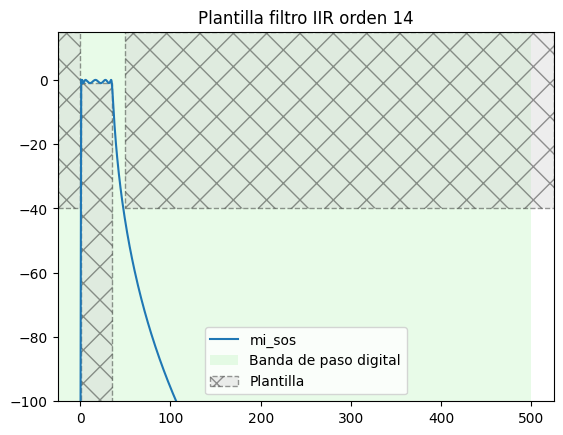

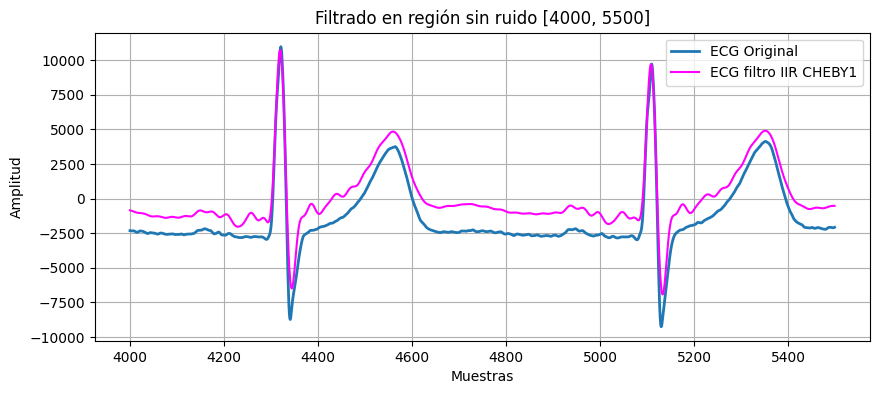

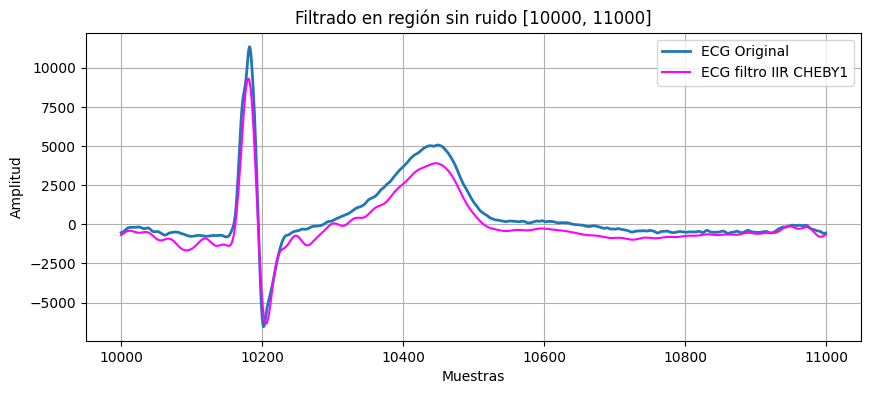

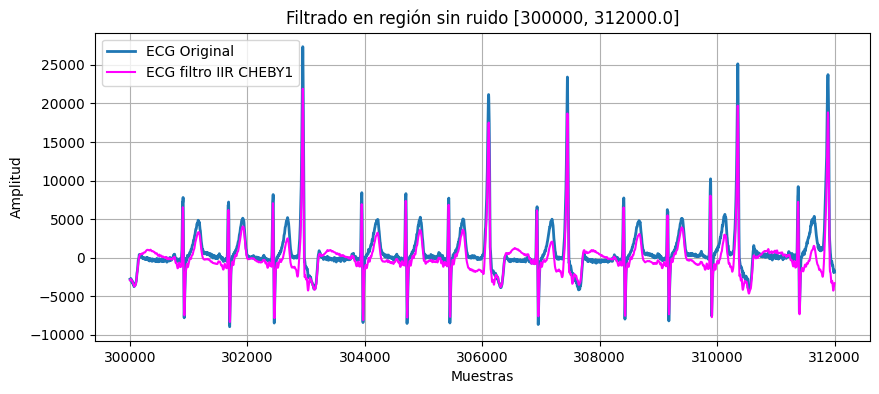

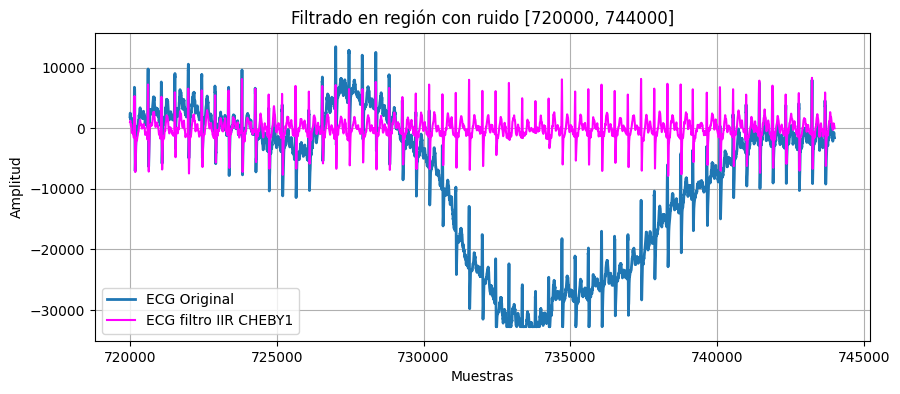

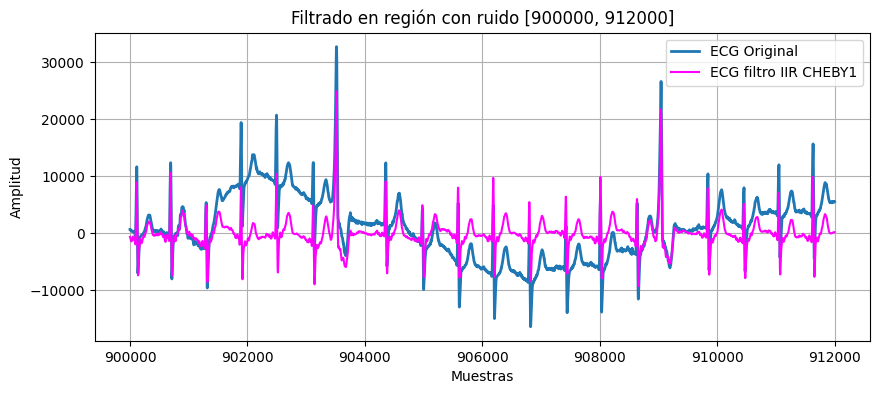

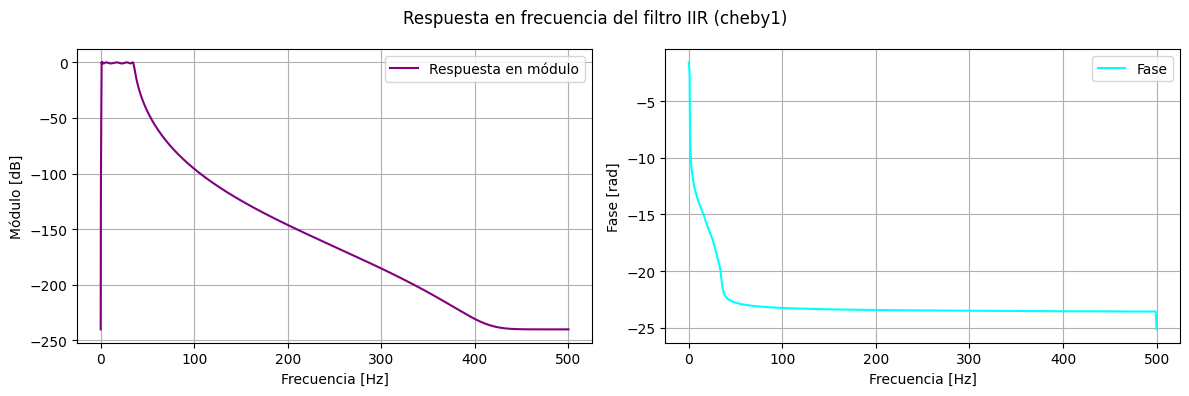

In [49]:
aprox_name = 'cheby1' #ripple en la banda pasante
mi_sos = sig.iirdesign(fpass, fstop, ripple, attenuation, ftype=aprox_name, output='sos',fs=fs)

orden_iir = mi_sos.shape[0] * 2  # cada sección SOS es un biquadro (orden 2)
print(f"Orden del filtro IIR: {orden_iir}")

#%%plantilla de diseño, para analizarlo
#npoints = 1000 #asi evalua equiespaciado
#para obtner mayor resuloción antesd e la bandad de paso, necesito un muestreo log => a freqz le puedo pasar un vector.
w_rad = np.append(np.logspace(-2,0.8,250), np.logspace(0.9,1.6,250))
w_rad = np.append(w_rad, np.linspace(40, nyq_frec, 500, endpoint=True) )/nyq_frec * np.pi

w, hh = sig.sosfreqz(mi_sos, worN=w_rad) #worN le puedo pasar un entero o un vector 

#orden_iir = mi_sos.shape[0] * 2  # cada sección SOS es un biquadro (orden 2)
#print(f"Orden del filtro IIR: {orden_iir}")

plt.plot(w/np.pi*nyq_frec, 20*np.log10(np.abs(hh)+1e-15), label='mi_sos')
plot_plantilla(filter_type = 'bandpass' , fpass = (fpass[0],fpass[1]), ripple = ripple , fstop = (fstop[0],fstop[1]), attenuation = attenuation, fs = fs)
plt.title(f'Plantilla filtro IIR orden {orden_iir}')
plt.legend()
plt.show()

mostrar_filtrado_ecg(ecg_one_lead, mi_sos, fs, etiqueta='ECG filtro IIR ' + aprox_name.upper(), tipo_filtro='IIR')

##-------------------- VISUALIZACIÓN RESPUESTA EN FRECUENCIA-----------------##
plt.figure(figsize=(12, 4))

# Respuesta en módulo
plt.subplot(1, 2, 1)
plt.plot( w / np.pi * nyq_frec, 20 * np.log10(np.abs(hh) + 1e-12), color='purple',label='Respuesta en módulo')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Módulo [dB]')
plt.grid(True)
plt.legend()

# Respuesta en fase (esto es antes de filtrar, para verificar que NO TIENEN FASE LINEAL LOS FILTROS IIR)
plt.subplot(1, 2, 2)
plt.plot( w / np.pi * nyq_frec, np.unwrap(np.angle(hh)), label='Fase', color='cyan')
plt.ylabel('Fase [rad]')
plt.xlabel('Frecuencia [Hz]')
plt.grid(True)
plt.legend()

plt.suptitle(f'Respuesta en frecuencia del filtro IIR ({aprox_name})')
plt.tight_layout()
plt.show()



Orden del filtro IIR: 10


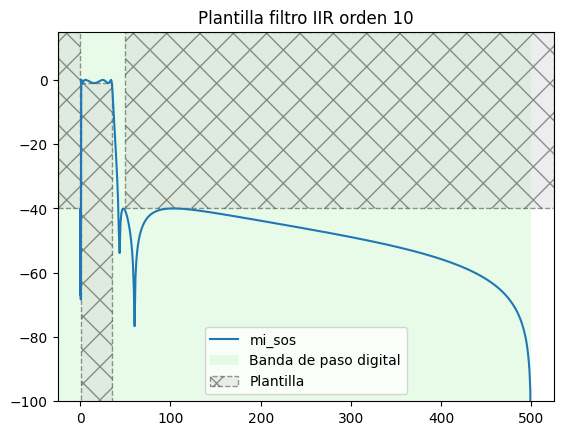

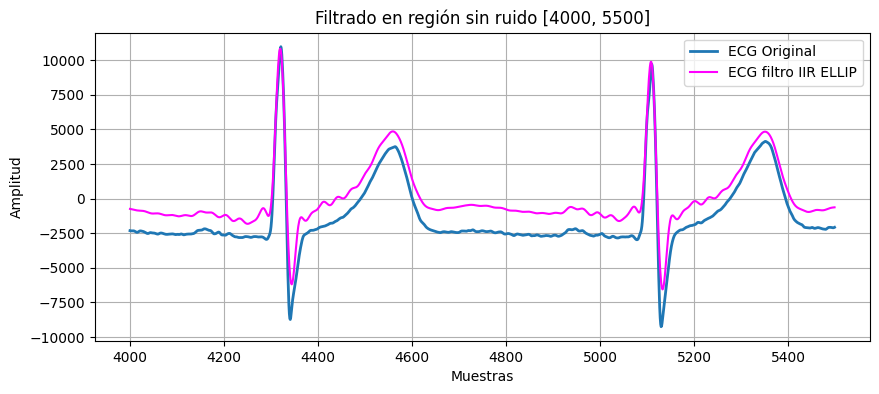

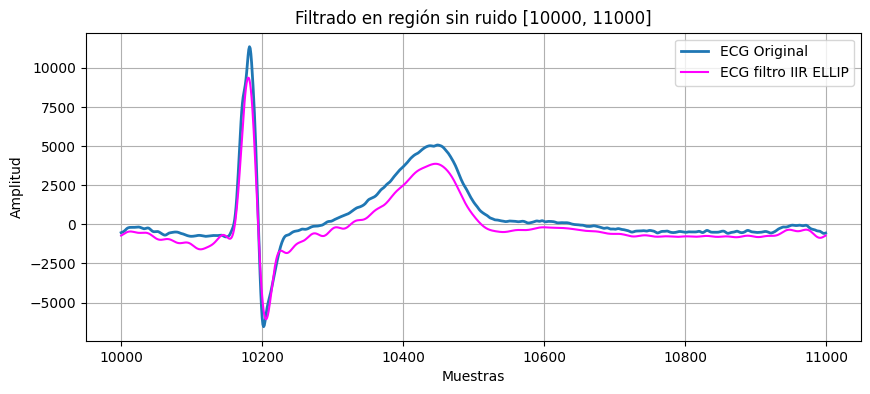

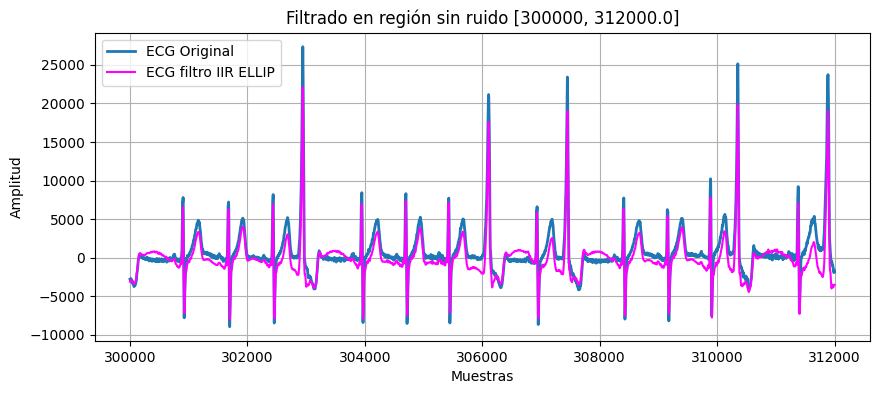

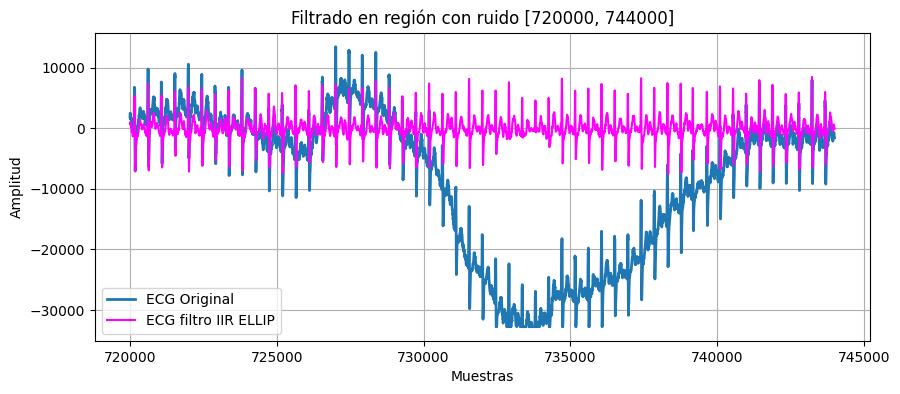

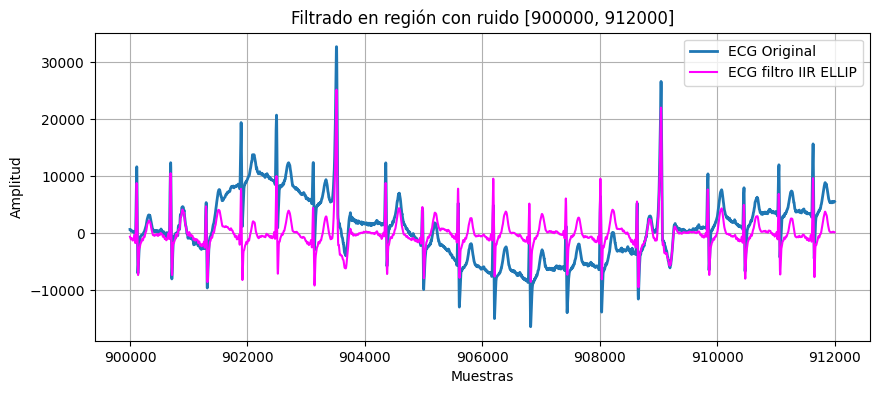

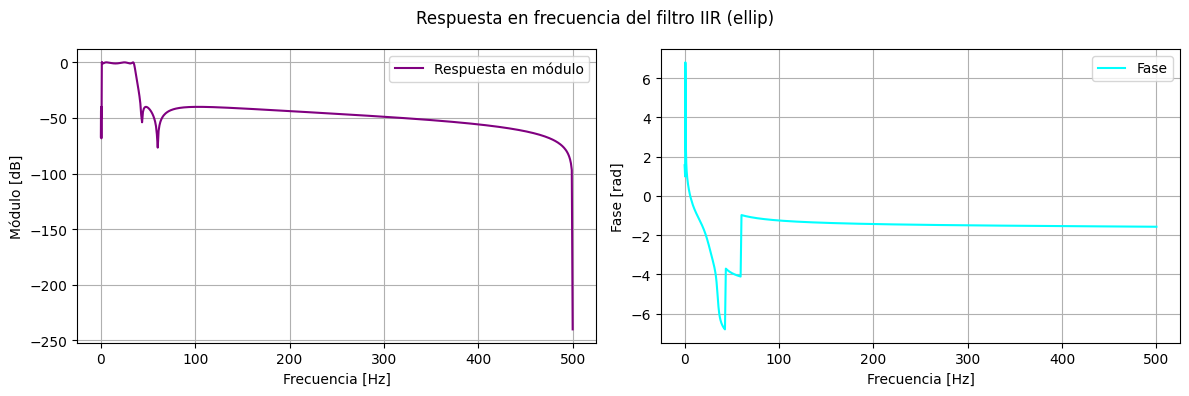

In [48]:
aprox_name = 'ellip'
mi_sos = sig.iirdesign(fpass, fstop, ripple, attenuation, ftype=aprox_name, output='sos',fs=fs)
# las columnas 3,4y5 son los coeficiente a0,a1,a2 y de la 0 a la 2 son los coef b

orden_iir = mi_sos.shape[0] * 2  # cada sección SOS es un biquadro (orden 2)
print(f"Orden del filtro IIR: {orden_iir}")

#%%plantilla de diseño, para analizarlo
npoints = 1000 #asi evalua equiespaciado

#para obtner mayor resuloción antesd e la bandad de paso, necesito un muestreo log => a freqz le puedo pasar un vector.
w_rad = np.append(np.logspace(-2,0.8,250), np.logspace(0.9,1.6,250))
w_rad = np.append(w_rad, np.linspace(40, nyq_frec, 500, endpoint=True) )/nyq_frec * np.pi

w, hh = sig.sosfreqz(mi_sos, worN=w_rad) #worN le puedo pasar un entero o un vector 
plt.plot(w/np.pi*nyq_frec, 20*np.log10(np.abs(hh)+1e-15), label='mi_sos')

plot_plantilla(filter_type = 'bandpass' , fpass = (fpass[0],fpass[1]), ripple = ripple , fstop = (fstop[0],fstop[1]), attenuation = attenuation, fs = fs)
plt.title(f'Plantilla filtro IIR orden {orden_iir}')
plt.legend()
plt.show()

mostrar_filtrado_ecg(ecg_one_lead, mi_sos, fs, etiqueta='ECG filtro IIR ' + aprox_name.upper(), tipo_filtro='IIR')

##-------------------- VISUALIZACIÓN RESPUESTA EN FRECUENCIA-----------------##
plt.figure(figsize=(12, 4))

# Respuesta en módulo
plt.subplot(1, 2, 1)
plt.plot( w / np.pi * nyq_frec, 20 * np.log10(np.abs(hh) + 1e-12), color='purple',label='Respuesta en módulo')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Módulo [dB]')
plt.grid(True)
plt.legend()

# Respuesta en fase (esto es antes de filtrar, para verificar que NO TIENEN FASE LINEAL LOS FILTROS IIR)
plt.subplot(1, 2, 2)
plt.plot( w / np.pi * nyq_frec, np.unwrap(np.angle(hh)), label='Fase', color='cyan')
plt.ylabel('Fase [rad]')
plt.xlabel('Frecuencia [Hz]')
plt.grid(True)
plt.legend()

plt.suptitle(f'Respuesta en frecuencia del filtro IIR ({aprox_name})')
plt.tight_layout()
plt.show()


### **Análisis: comparación filtros IIR**

En el dsieño de lo tres filtros, se utilizó la función de scipy **singal.filtfilt** (filtro forward-backward) para filtrar la señal debido a que no cuentan con una fase lineal, como se aclaró previamente, debido justamente a su recursividad. Entonces, al tener una respuesta de fase no lineal, como puede observarse en los gráficos presentados, implica que diferentes frecuencias se retrasan en el tiempo de forma diferente resultando en una distorsión de la señal (en nuestro caso es fundamental preservar la forma de onda). Por lo tanto, este modo de filtrar lo que hace es en primer lugar aplicar el filtro normalmente (distorsiona la fase) y luego invierte la señal resultante y aplica el filtro de nuevo; invirtiendo el resultado final para obtener la señal correcta: es por esto que además en este caso (filtros IIR) no vemos un retardo de grupo en la señal filtrada como lo haciamos en el caso de los FIR. 

 - **Butterwoth:** Cómo puede observarse en el gráfico de la respuesta en frecuencia de módulo al ser de máxima planicidad en la banda de paso implica que no presenta ripple, ondulaciones, en la banda de paso por lo tanto representa una respuesta suave entre la banda de paso y la atenuación. Sin embargo para lograr especificaciones exigentes (por ejemplo, una transición abrupta), requiere un orden más alto comparado con los siguientes filtros IIR, lo que puede aumentar el costo computacional.

 - **Chebyshev I:**
En este caso, tenemos ripple controlado en la banda de paso, lo que permite una pendiente de transición más abrupta entre banda de paso y de atenuación, en comparación con Butterworth; es decir tiene una mayor pendiente (lo cuál puede observarse en el gráfico de la respuesta de módulo). Esto lo consigue con un menor orden que el Butterworth lo que lo hace más eficiente aunque a costa de cierta irregularidad en la ganancia dentro de la banda útil.

 - **Cauer (elíptico):**
Presenta ripple tanto en la banda de paso como en la banda de atenuación, pero su transición es aún más rapida (mayor pendiente) que los filtros IIR previos, con un menor orden. Esto permite cumplir especificaciones estrictas con el menor orden posible, aunque también es el que introduce más distorsión en amplitud. 

En conclusión los filtros IIR consiguen cumplir con la plantilla, exigencias, determinadas con mayor facilidad; es decir con un menor orden. Sin emabargo, NO tienen una fase lineal, por lo tanto DISTORSIONAN la forma de onda; que en el caso de analizar señales fisolóigicas es de vital importancia preservar la misma para así poder detectar patologías. Además dada su naturaleza recursiva los errores de cuantización suelen acumpularse. 

En cambio, los filtros FIR tienen una fase LINEAL garantizada (si es diseñado concoeficientes simétricos) y así preserva la forma original de la señal, lo que resulta clave en esta caso. Pero como presentan un retardo de grupo no los hace ideal para usar en tiempo real, solo cuando es prioridad conservar la forma de onda. Cabe destacar que para cumplir con las exigencias requieren de un orden muy elevado lo que resulta en un costo computacional mayor. 
